### MNIST digit prediction
<br>
In this excercise I am using MNIST dataset, which is a set of 70000 small images of digits handwritten by high school students and employees of the US census bureau. The task is to predict the digits in the images corectly.
<br><br>
Its a Supervised learning task, since we are given the labeled trainign data.<br>
Its a classification task, since we are asked to predict the class (or which digit it is) of the digit image.<br>
Its a batch learning ML system, since its not a continous flow of data and we don't have to adjust the changing data rapidly.

In [1]:
#We need to check correct versions of Python and skLearn. Also import all the common packages at this point.

import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get the data from sklern for MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
# There are 70000 images and each image has 784 features 
# i.e. each image is 28 * 28 pixels
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [4]:
y.shape

(70000,)

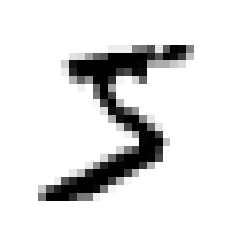

In [5]:
# Lets look at one of the digit using matpltlib
some_digit = x[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# It looks like 5, lets comfirm
y[0]

'5'

In [7]:
# Lets cast label to integer since most ML algos expect integers
y = y.astype(np.uint8)

In [8]:
# MNIST dataset is already split into training and test sets
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

# Classification can be of two types Binary and Multiple.
<br>
<b>Binary Classifier</b><br>
Lets simplify and try to identify only one digit for example 5. This "5-detector" will be an example of binary classifier, distingusing between two classes 5 and not-5.

In [9]:
# Creating target vector for this classification task
y_train_5 = (y_train == 5) # True for all 5's false for all others
y_test_5 = (y_test == 5)

In [10]:
# lets use SGDClassifier to train
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit]) # It predicts image 5 correctly

array([ True])

In [12]:
# Performance evaluation
# Lets look at confusion matrix
# To compute confusion matrix we need to have a set of predictions so that they can be compared to actual targets.

from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3) 

In [13]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [14]:
# Lets look at precision and recall scores
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict) # TP / (TP + FP)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_predict) # TP / (TP / FN)

0.6511713705958311

In [16]:
# Lets look at F1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict) # TP / (TP + (FN + FP) / 2)

0.7325171197343846

In [17]:
# Lets plot precision and recall against all the possibe thresholds

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

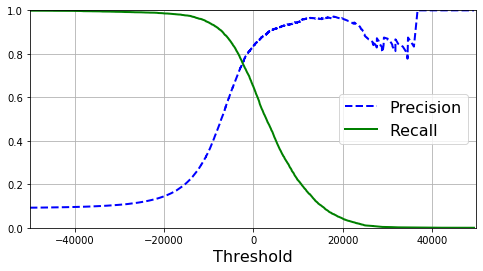

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1]) 

plt.figure(figsize=(8, 4))  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

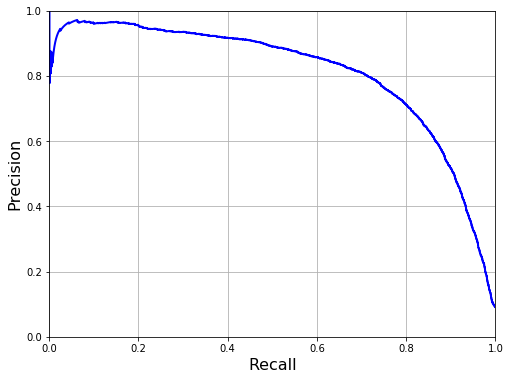

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [22]:
# As we can see precision starts to fall sharply around 80% recall. 
# We will have to select precision / recall tradeoff just before that drop. But the choise depends on the project requirements.
# Suppose for example we decide on 90% precision
# We need to search for lowest threshold which gives us 90% precision

thresh_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [23]:
thresh_90_precision

3370.0194991439594

In [24]:
y_train_pred_90 = (y_scores >= thresh_90_precision)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [28]:
# lets try another metrics used with binary classifiers i.e. ROC curve. It plots TPR against FPR.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

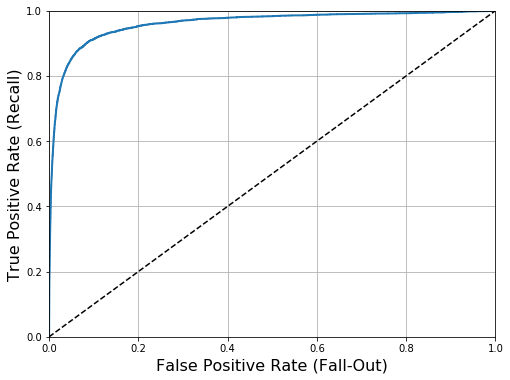

In [29]:
# The dotted line represents ROC curve, a good classifier stays as far away from that line as possible 
# i.e. towards the top-left corner. 

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])  
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)  

plt.figure(figsize=(8, 6))   
plot_roc_curve(fpr, tpr)   
plt.show()

In [30]:
# One way to compare classifiers is to compare AUC

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [31]:
# Lets now train RandomForestClassifier and compare its ROC and ROC AUC to those of SGDClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3,
                                    method="predict_proba")

In [32]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

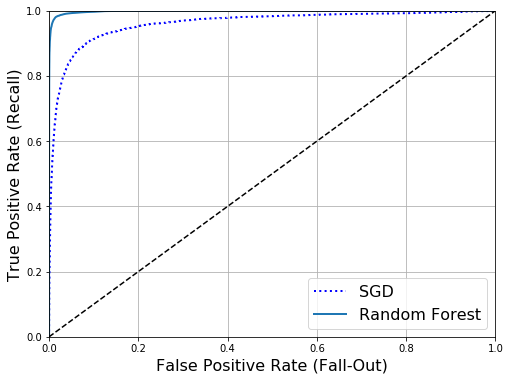

In [33]:
# Its clear that RandomForestClassifier is a better performer
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [36]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

<b>Multiclass classification</b>

In [38]:
# Lets train on Support vector machine
# Running on lesser records i.e. 1000 for faster processing on my machine

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(x_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
digit_scores = svm_clf.decision_function([some_digit])
digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [41]:
np.argmax(digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
# Lets train on SGDClassifier
sgd_clf.fit(x_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017536,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [46]:
# Evaluating the model now

y_train_pred = cross_val_predict(sgd_clf, x_train[:1000], y_train[:1000], cv=3)
conf_mx = confusion_matrix(y_train[:1000], y_train_pred)
conf_mx

array([[ 91,   0,   1,   0,   0,   4,   0,   0,   1,   0],
       [  0, 106,   1,   0,   0,   4,   0,   0,   5,   0],
       [  2,   4,  75,   3,   3,   2,   1,   2,   6,   1],
       [  1,   1,   9,  66,   0,  11,   0,   2,   0,   3],
       [  0,   0,   1,   1,  89,   2,   2,   0,   5,   5],
       [  1,   0,   1,   6,   3,  66,   2,   0,  10,   3],
       [  1,   1,   2,   0,   0,   4,  82,   0,   3,   1],
       [  1,   2,   3,   1,   3,   0,   0, 101,   2,   4],
       [  0,   3,   1,   2,   0,   7,   0,   1,  68,   5],
       [  1,   1,   1,   3,   5,   6,   1,   9,   8,  65]], dtype=int64)

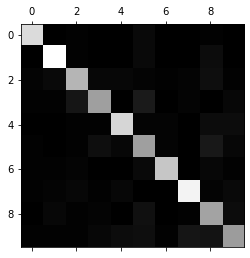

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

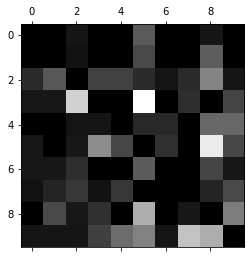

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()